<a href="https://colab.research.google.com/github/ibenatar-96/tiger-pomdp-mplr/blob/main/tiger_pomdp_mplr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install numpyro
!pip install funsor

In [2]:
import numpy as np
import numpyro
import numpyro.distributions as dist
import numpyro.distributions.constraints as constraints
import matplotlib.pyplot as plt
import scipy.stats as stats
import funsor
import pandas as pd
import seaborn as sns
import jax
import jax.numpy as jnp
import sys
import os
import time
import copy
import random
import arviz as az
from itertools import product

numpyro.set_host_device_count(4)

# Tiger POMDP (Partially Observable Markov Decision Process)

The Tiger POMDP is a classical problem in the field of artificial intelligence and decision-making under uncertainty. It's used to illustrate the challenges of decision-making when there's uncertainty about the state of the environment.

In the Tiger POMDP scenario, an agent is placed in a room with two doors. Behind one door is his freedom, and behind the other is a tiger. The agent doesn't know which door leads to which outcome. It can take actions like "listen" to hear a sound indicating the location of the tiger or "open" a door to reveal its contents. However, actions are imperfect, leading to uncertainty.

Solving the Tiger POMDP involves finding a policy that maximizes the expected cumulative reward over time, taking into account the uncertainty and partial observability. Various algorithms, such as belief state planning or particle filtering, can be used to approximate or solve POMDPs.

The Tiger POMDP can be represented as a Partially Observable Markov Decision Process (POMDP) defined by the tuple $(S, A, T, R, Ω, O, γ)$, where:

\\
$S$: The finite set of states consists of two elements representing the locations of the tiger and his freedom.

$A$: The finite set of actions available to the agent includes "listen" and "open" representing actions to gather information or make decisions.

$T$: The state transition function $T: S \times A \mapsto S$ describes the transition probabilities between states based on actions. For example, if the agent decides to "open" a door, the state transition function will determine the probabilities of transitioning to either the tiger or freedom state.

$R$: The reward function $R: S \times A \mapsto \mathbb{R}$ provides immediate rewards for actions in specific states. For instance, opening the door containing his freedom could yield a positive reward, while opening the door with the tiger will result in a negative reward.

$Ω$: The finite set of observations consists of two elements representing the possible observations of "tiger-left" and "tiger-right" when the agent chooses to "listen".

$O$: The set of conditional observation probabilities $Ω$ specifies the likelihood of observing each possible observation given the true state of the environment.

$γ$: The discount factor $γ \in [0,1]$ accounts for the importance of future rewards relative to immediate rewards in the agent's decision-making process.

## Generating "Synthetic" Observations.

Now let's create synthetic observations / data for our model to learn from.

This synthetic data is following the rules of the original Tiger POMDP problem,
where the probability of getting a correct observation when doing "listen" action is 0.85.

Our observations will be in the form of a list that consists of episodes:

$b_{0},(a_{0},o_{0}),(a_{1},o_{1}),...,(,a_{n},o_{n})$

Where $(a_{t},o_{t})$ -

$a_{t}$ - the action taken in time step $t$

$o_{t}$ - the observation recieved at time step $t$

$\Omega = \{o_{tl}, o_{tr}\} $

Where $O(s',a,o) = P(o_{tl}|s',a_{listen}) = P(o_{tr}|s',a_{listen}) =
\begin{align}
     \left\{
        \begin{array}{cl}
        0.85 & \text{if s' == s}  \\
        0.15 & \text{if s' != s}
        \end{array}
    \right.
\end{align}$

\

$O(s'_{tl},a_{listen},o_{tl}) = 0.85$

$O(s'_{tl},a_{listen},o_{tr}) = 0.15$

$O(s'_{tr},a_{listen},o_{tl}) = 0.15$

$O(s'_{tr},a_{listen},o_{tr}) = 0.85$


The context here of s' is that I have "reached" the state that the action took me to.
Meaning - for example, we know that $a_{listen}$ keeps us in the same state, so if the real tiger location is behind the left door - acting $a_{listen}$ will result in s' = "tiger-left", and the probability of observing $o_{tl}$ is 0.85, and the probability of observing $o_{tr}$ is 0.15.

* When action $a$ is "open-left" or "open-right", then recieving $o_{tl}$ and $o_{tr}$ are evenly distributed (uniformly).

Explanation - Observing the correct state occurs with probability 0.85, for example when the state is $s_{tl}$ (meaning the tiger is behind the left door), we will recieve the correct observation - $o_{tl}$ (that the tiger is behind the left door) with probability 0.85, and we will recieve the incorrect observation - $o_{tr}$ with probability 0.15.

In [3]:
Actions = ["listen", "open-left", "open-right"]
States = ["tiger-left", "tiger-right"]
Observations = ["tiger-left", "tiger-right"]
Inital_Belief_State = {"tiger-left": 0.5, "tiger-right": 0.5}
Terminate_Actions = ["open-left", "open-right"]

# Observation Model: {(state-prime, action): {observation1: probability1, observation2: probability2}}
Observation_Model = {("tiger-left","listen"): {"tiger-left": 0.85,
                                               "tiger-right": 0.15},
                     ("tiger-right","listen"): {"tiger-left": 0.15,
                                                "tiger-right":0.85},
                     ("tiger-left","open-left"): {"tiger-right":0.5,
                                                   "tiger-left":0.5},
                     ("tiger-right","open-left"): {"tiger-right":0.5,
                                                   "tiger-left":0.5},
                     ("tiger-left","open-right"): {"tiger-right":0.5,
                                                   "tiger-left":0.5},
                     ("tiger-right","open-right"): {"tiger-right":0.5,
                                                   "tiger-left":0.5}}

# Transition Model: {(state, action): {state-prime1: probability1, state-prime2: probability2}}
Transition_Model = {("tiger-left","listen"): {"tiger-left": 1.0,
                                               "tiger-right": 0.0},
                     ("tiger-right","listen"): {"tiger-left": 0.0,
                                                "tiger-right":1.0},
                     ("tiger-left","open-left"): {"tiger-right":0.5,
                                                   "tiger-left":0.5},
                     ("tiger-right","open-left"): {"tiger-right":0.5,
                                                   "tiger-left":0.5},
                     ("tiger-left","open-right"): {"tiger-right":0.5,
                                                   "tiger-left":0.5},
                     ("tiger-right","open-right"): {"tiger-right":0.5,
                                                   "tiger-left":0.5}}

### Generating Observations function.

This function creates synthetic observations depending on the following modes and guidelines:

**Guidelines:**
* A state for the tiger is sampled from Categorical([0.5,0.5]) distribution.
* Depending on the tiger state, the listen probability is 0.85 to recieve the correct observation, and 0.15 to recieve incorrect obs.
* Open action yields the correct observation (the location of the tiger) with probability 1.
* We will choose to open the door based on the last listen observation recieved.
* In each call to gen_obs, we create {num_samples} observations, where each observation is an episode log [(action, observation), ...]

**Modes:**
1. **'first'** - This is our first use case, which is composed of 2 actions and 2 observations, the first being 'listen', and the second action 'open' is based on the last 'listen' observation, as such:

**[('listen', listen_observation), ('open-', open_observation)]**

For example:

**[('listen', 'tiger-right'), ('open-right', 'tiger-right')]**

2. **'second'** - This is our second use case, were we generate an incomplete (missing values) data matrix.
    * in even rows, we create an episode that is composed of one 'listen' action and one 'open' action.
    * in odd rows, we create an episode that is composed of two 'listen' actions and one 'open' action.
**[('listen', listen_observation), ('open-', open_observation)]**
**[('listen', listen_observation_1), (listen, listen_observation_2),('open-', open_observation)]**

In [4]:
def gen_obs(num_samples=15, mode='first', debug=True):
    episodes_obs = []
    for _ in range(num_samples): # create num_samples episodes
        episode_log = []
        tiger_state = np.random.choice(States, size=None)
        listen_probs = [0.85, 0.15] if tiger_state == 'tiger-left' else [0.15, .85]
        listen_obs = np.random.choice(Observations, size=None, p=listen_probs)
        episode_log.append(("listen", listen_obs))
        if mode == 'second' and _ % 2 == 1:
            listen_obs = np.random.choice(Observations, size=None, p=listen_probs)
            episode_log.append(("listen", listen_obs))
        open_obs = np.random.choice(Observations, size=None, p=[1 if state == tiger_state else 0 for state in States])
        episodes_obs.append(episode_log + [(listen_obs.replace("tiger", "open"), open_obs)])
    if debug:
        for i in range(min(num_samples, 5)):
            print(f"obs[{i}] = {episodes_obs[i]}")
        print(sum(1 for obs in episodes_obs if obs[-2][1] == obs[-1][1])/num_samples)
    return episodes_obs

In [5]:
num_samples=20
observations = gen_obs(num_samples=num_samples, mode='first')

obs[0] = [('listen', 'tiger-right'), ('open-right', 'tiger-right')]
obs[1] = [('listen', 'tiger-left'), ('open-left', 'tiger-left')]
obs[2] = [('listen', 'tiger-left'), ('open-left', 'tiger-left')]
obs[3] = [('listen', 'tiger-right'), ('open-right', 'tiger-right')]
obs[4] = [('listen', 'tiger-left'), ('open-left', 'tiger-left')]
0.9


Transforming the data matrix into a panda data frame.

In [6]:
def transform_df(observations):
    data = []
    columns = []
    max_length = max(len(episode) for episode in observations)
    for i in range(max_length):
        columns.append(f'action{i}')
        columns.append(f'obs{i}')
    for episode in observations:
        row = {}
        for i, (a, o) in enumerate(episode):
            row[f'action{i}'], row[f'obs{i}'] = a, o
        data.append(row)
    return pd.DataFrame(data, columns=columns)


data = transform_df(observations)
data.head()

,action0,obs0,action1,obs1
0,listen,tiger-right,open-right,tiger-right
1,listen,tiger-left,open-left,tiger-left
2,listen,tiger-left,open-left,tiger-left
3,listen,tiger-right,open-right,tiger-right
4,listen,tiger-left,open-left,tiger-left


### Posterior approximation

We will use this function to get a general sense of how our posterior should look like.

The function calculates the posterior distribution for the probability of listening (p_listen) by evaluating the likelihood for each value of p_listen (x-axis) based on the number of 'listen' actions observed and the number of correct listens. Correct listens are defined as the 'listen' actions that matched the subsequent observations revealing the correct state. This approximation helps us visualize the most probable values of p_listen given our data.

In [177]:
def posterior_approximation(df):
    num=1000
    p_grid = jnp.linspace(start=0, stop=1, num=num)
    prior = jnp.repeat(1, num)

    listen_attempts = 0
    listen_success = 0
    for column in df:
        listen_attempts += df[column].eq('listen').sum()
    for i, row in df.iterrows():
        obs_columns = [col for col in row.index if col.startswith('obs') and not pd.isna(row[col])]
        for column in obs_columns[:-1]:
            if row[column] == row[obs_columns[-1]]:
                listen_success += 1
    print(f"listen_attemps: {listen_attempts}, listen_success: {listen_success}")

    likelihood = jnp.exp(dist.Binomial(total_count=listen_attempts, probs=p_grid).log_prob(listen_success))
    unstd_posterior = likelihood * prior
    std_posterior = unstd_posterior / jnp.sum(unstd_posterior)

    mean_posterior = jnp.sum(p_grid * std_posterior)
    cumulative_posterior = jnp.cumsum(std_posterior)
    median_posterior = p_grid[jnp.searchsorted(cumulative_posterior, 0.5)]
    plt.plot(p_grid, std_posterior, '-o', linewidth=3, markersize=1, label='Posterior')
    plt.axvline(mean_posterior, color='red', linestyle='--', label=f'Mean: {mean_posterior:.2f}')
    plt.axvline(median_posterior, color='green', linestyle='--', label=f'Median: {median_posterior:.2f}')
    plt.xlabel("p_listen")
    plt.ylabel("posterior probability")
    plt.title("Poster approximation")
    plt.legend()
    plt.show()

listen_attemps: 20, listen_success: 18


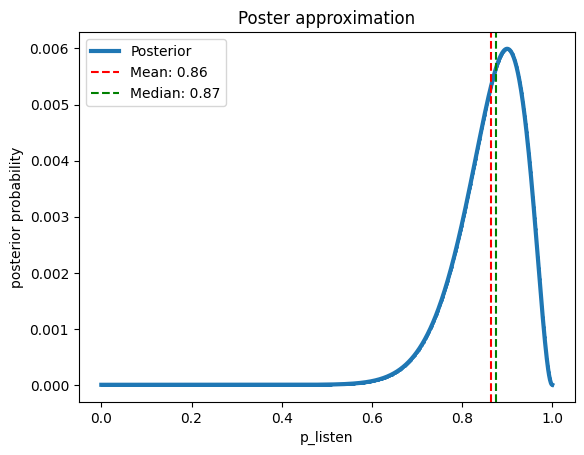

In [178]:
posterior_approximation(data)

### Data Preprocessing
This function converts the categorical data in the dataframe into numeric values for easier processing and analysis.

The function preprocess_data maps actions and observations to numeric values. Actions (listen, open-left, open-right) are mapped to 0, 1, and 2 respectively, while observations (tiger-left, tiger-right) are mapped to 0 and 1. This conversion is applied to the appropriate columns in the dataframe, resulting in a new dataframe with numeric values instead of categorical strings. This numeric representation is essential for subsequent modeling and analysis steps.

In [9]:
# Now lets preprocess the data and turn it into numeric values, so we can work with numpyro.

def preprocess_data(df):
    actions = ["listen", "open-left", "open-right"] # listen = 0, open-left = 1, open-right = 2
    observations = ["tiger-left", "tiger-right"] # tiger-left = 0, tiger-right = 1
    action_map = {action: i for i, action in enumerate(actions)}
    obs_map = {obs: i for i, obs in enumerate(observations)}
    df_numeric = df.copy()
    for col in df.columns:
        if col.startswith('action'):
            df_numeric[col] = df[col].map(action_map)
        elif col.startswith('obs'):
            df_numeric[col] = df[col].map(obs_map)
    return df_numeric

data_numeric = preprocess_data(data)
data_numeric.head()

,action0,obs0,action1,obs1
0,0,1,2,1
1,0,0,1,0
2,0,0,1,0
3,0,1,2,1
4,0,0,1,0



# Model

## POMDP definition

 **0 - tiger-left, 1 - tiger-right**

 $States$ = {0, 1}

 $\Omega$ = {0, 1}

$Actions$ = {Listen, Open}

 $Observations$ =
* $\text{State = 0, Action = Listen} \Rightarrow p_l, 1-p_l$ -- If we choose to Listen and the State is 0, we will recieve observation 0 (Left) with probability $p_l$ and 1 (Right) with probability $1-p_l$
* $\text{State = 1, Action = Listen} \Rightarrow 1-p_l, p_l$ -- If we choose to Listen and the State is 1, we will recieve observation 0 (Left) with probability $1-p_l$ and 1 (Right) with probability $p_l$
* $\text{State = 0, Action = Open} \Rightarrow 1, 0$ -- If we choose to Open and the State is 0, we will always recieve observation 0 (Left) [probability is 1].
* $\text{State = 1, Action = Open}, \Rightarrow 0, 1$ -- If we choose to Open and the State is 1, we will always recieve observation 1 (Right) [probability is 1].


## Parameter learning

$\epsilon = 0.01$ // Approximate Bayesian computation

$p_0 \sim Beta(1, 1)$ Sampling probability for initial state\
$p_l \sim Beta(1, 1)$ Sampling probability for listen observations

$s \sim Bernoulli(p_0)$ Sampling Initial state (s0)


$\text{for a, o in history:}$
* $\text{if a == listen:}$
    * $\text{if s == 0: (if state is 'tiger-left')}$
        * $o \sim Bernoulli(1-p_l)$
    * \$text{elsif s == 1 (if state is 'tiger-right'):}$
        * $o \sim Bernoulli(p_l)$
* $\text{elsif a == open:}$
    * $\text{if s == 0:}$
        * $o \sim Bernoulli(\epsilon)$
    * $\text{elsif s == 1:}$
        * $o \sim Bernoulli(1-\epsilon)$

In [10]:
def model1(data):
    epsilon = 0.01
    p_listen = numpyro.sample("p_listen", dist.Beta(1,1))
    # p_0 = numpyro.deterministic("p_0", 0.5)
    p_0 = numpyro.sample("p_0", dist.Beta(1,1))
    n_episodes = data.shape[0]
    actions = data[[col for col in data.columns if col.startswith('action')]].values
    observations = data[[col for col in data.columns if col.startswith('obs')]].values
    for episode in range(n_episodes):
        s = numpyro.sample(f"s_{episode}", dist.Categorical(probs=jnp.array([p_0, 1-p_0])), infer={'enumerate': 'parallel'})
        a = actions[episode, :]
        o = observations[episode, :]
        for i, action in enumerate(a):
            if action == 0:
                p = jnp.where(s == 1, p_listen, 1 - p_listen)
                numpyro.sample(f"obs_{episode}_{i}", dist.Bernoulli(p), obs=o[i])
            elif action and not np.isnan(action):
                p = jnp.where(s == 1, 1 - epsilon, epsilon)
                numpyro.sample(f"obs_{episode}_{i}", dist.Bernoulli(p), obs=o[i])

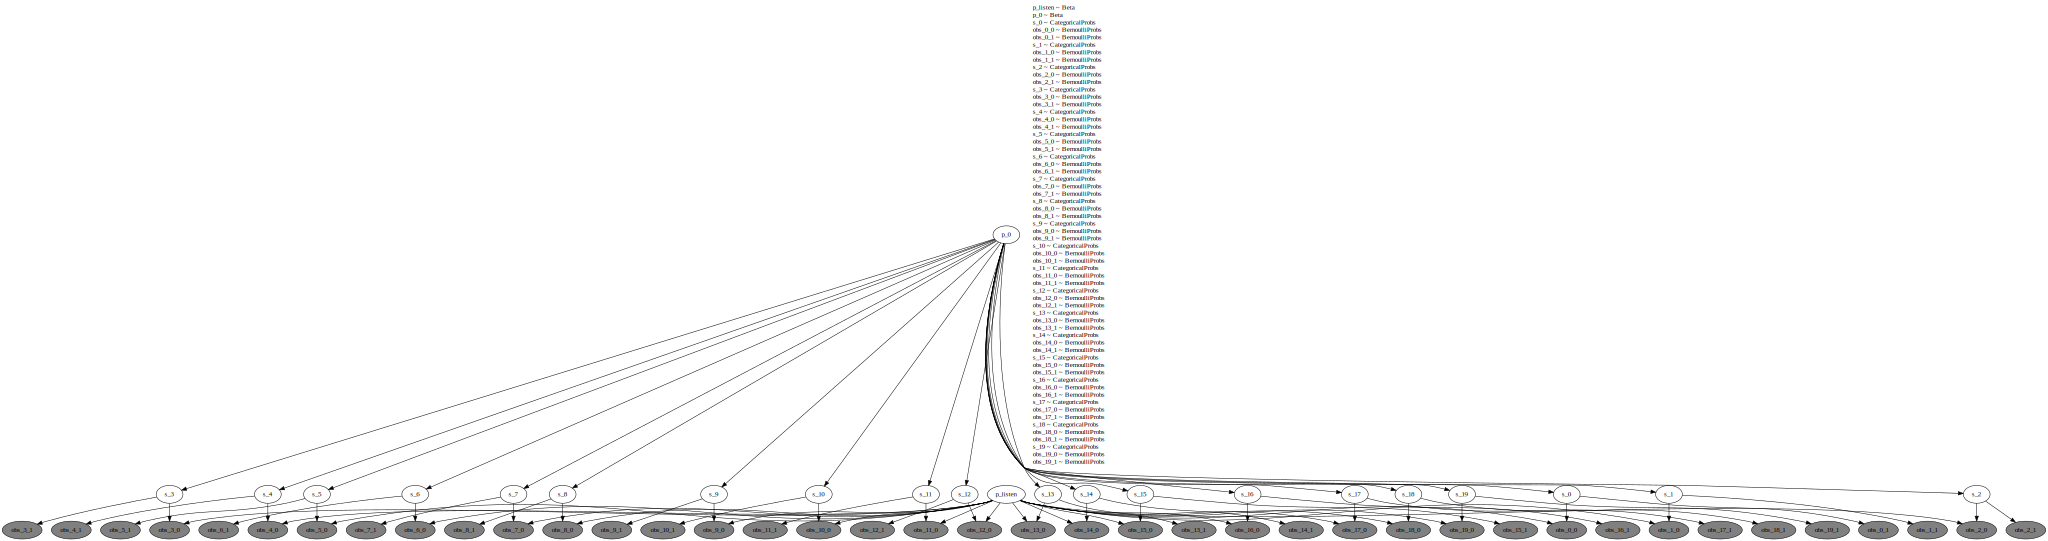

In [11]:
numpyro.render_model(model1, model_args=(data_numeric,), render_distributions=True, render_params=True,)

In [136]:
def model2(data):
    epsilon = 0.01
    p_listen = numpyro.sample("p_listen", dist.Beta(1, 1))
    p_0 = numpyro.sample("p_0", dist.Beta(1, 1))
    n_episodes = data.shape[0]
    actions = data[[col for col in data.columns if col.startswith('action')]].values
    n_actions = actions.shape[1]
    observations = data[[col for col in data.columns if col.startswith('obs')]].values

    with numpyro.plate("episodes", n_episodes, dim=-1):
        s = numpyro.sample("s", dist.Categorical(probs=jnp.array([p_0, 1 - p_0])), infer={'enumerate': 'parallel'})

        for i in range(n_actions):
            a = actions[:, i]
            o = observations[:, i]

            # This mask is applied in cases where we have imcomplete data (NaN) in our data matrix.
            # This happens because not all of our episodes are the same length.
            not_nan_mask = ~np.isnan(o)

            p_listen_cond = jnp.where(s == 1, p_listen, 1 - p_listen)
            p_action_cond = jnp.where(s == 1, 1 - epsilon, epsilon)

            p = jnp.where(a == 0, p_listen_cond, p_action_cond)

            # valid_o is the same as o, but without the NaN instances - replaced NaN with 0.
            valid_o = jnp.where(not_nan_mask, o, 0)
            # valid_p sets 1 in the parellel location where o is Nan.
            # Meaning - if o[i] is NaN: then p[i] = 1.
            # This is in order to create "dummy" values and situations, where p[i] = 1 and o[i] = 0, which will never be accepted and not calculated in the likelihood.
            valid_p = jnp.where(not_nan_mask, p, 1)

            # Only include valid observations in the likelihood
            numpyro.sample(f"obs_{i}", dist.Bernoulli(valid_p), obs=valid_o)

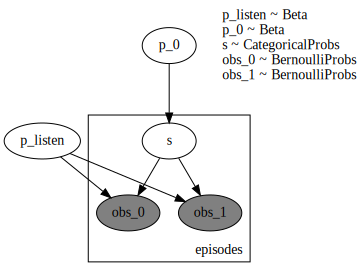

In [137]:
numpyro.render_model(model2, model_args=(data_numeric,), render_distributions=True, render_params=True,)

In [24]:
def inference(ai_model, data):
    nuts_kernel = numpyro.infer.NUTS(ai_model)
    mcmc = numpyro.infer.MCMC(
        nuts_kernel,
        num_warmup=500,
        num_chains=4,
        num_samples=5000)
    mcmc.run(jax.random.PRNGKey(int(time.time() * 1E6)), data=data)
    mcmc.print_summary()
    return mcmc

In [106]:
mcmc_1 = inference(model1, data_numeric)

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       p_0      0.41      0.10      0.40      0.23      0.57  15985.99      1.00
  p_listen      0.87      0.07      0.88      0.77      0.99  16118.09      1.00

Number of divergences: 0


In [107]:
mcmc_2 = inference(model2, data_numeric)

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       p_0      0.40      0.10      0.40      0.23      0.57  12933.55      1.00
  p_listen      0.87      0.07      0.88      0.77      0.99  14979.32      1.00

Number of divergences: 0


### Plotting Posterior Samples

This function visualizes the posterior distribution of a parameter by plotting the samples drawn during MCMC inference.

In [185]:
# Plotting the samples
def plot_samples(mcmc_samples):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, (name, samples) in enumerate(mcmc_samples.items()):
        sns.histplot(samples, kde=True, label=name)
        plt.axvline(jnp.mean(samples), color=colors[i % len(colors)], linestyle='--', label=f'Mean: {jnp.mean(samples):.2f}')
        plt.axvline(jnp.median(samples), color=colors[i % len(colors)], linestyle='--', label=f'Median: {jnp.median(samples):.2f}')
        plt.xlabel(name)
        plt.ylabel('Density')
    plt.title(f'Posterior distribution of MCMC samples')
    plt.legend()
    plt.show()

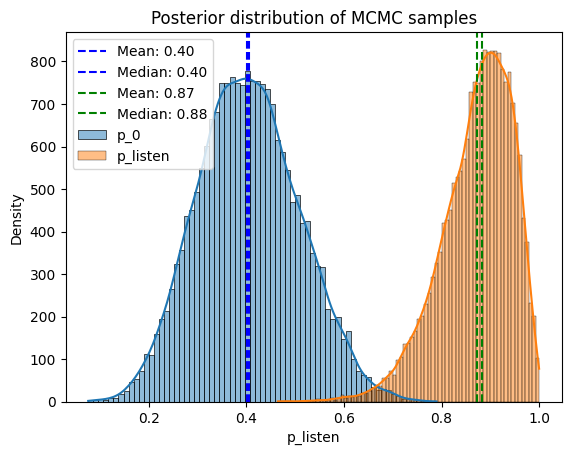

In [186]:
samples = mcmc_2.get_samples()
plot_samples(samples)

### Missing data / various episodes lengths.

Now let's look at a case where the data we have has missing values - this occurs because not all of the episodes are the same length.
\
For example - some episodes can be 2 actions before reaching terminate state, and some could be more.

We will generate a data matrix, where each second episode has another 'listen' action before trying to open the door (and reaching terminal satte).

In [87]:
observations_2 = gen_obs(num_samples=20, mode='second')

obs[0] = [('listen', 'tiger-right'), ('open-right', 'tiger-right')]
obs[1] = [('listen', 'tiger-right'), ('listen', 'tiger-right'), ('open-right', 'tiger-right')]
obs[2] = [('listen', 'tiger-left'), ('open-left', 'tiger-left')]
obs[3] = [('listen', 'tiger-left'), ('listen', 'tiger-right'), ('open-right', 'tiger-left')]
obs[4] = [('listen', 'tiger-right'), ('open-right', 'tiger-right')]
0.85


In [89]:
data_2 = transform_df(observations_2)
data_2.head()

,action0,obs0,action1,obs1,action2,obs2
0,listen,tiger-right,open-right,tiger-right,NaN,NaN
1,listen,tiger-right,listen,tiger-right,open-right,tiger-right
2,listen,tiger-left,open-left,tiger-left,NaN,NaN
3,listen,tiger-left,listen,tiger-right,open-right,tiger-left
4,listen,tiger-right,open-right,tiger-right,NaN,NaN


listen_attemps: 30, listen_success: 26


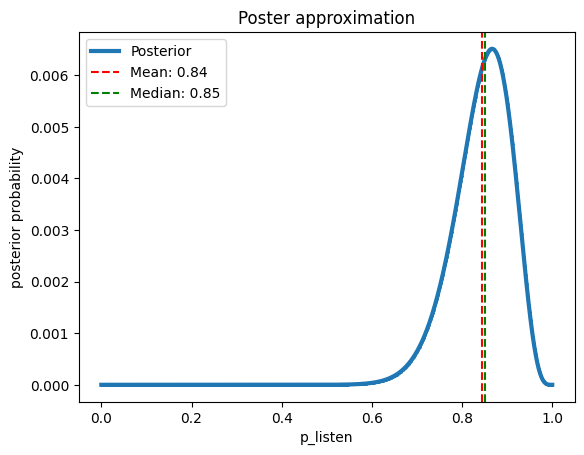

In [179]:
posterior_approximation(data_2)

In [181]:
data_numeric_2 = preprocess_data(data_2)
data_numeric_2.head()

,action0,obs0,action1,obs1,action2,obs2
0,0,1,2,1,NaN,NaN
1,0,1,0,1,2.0,1.0
2,0,0,1,0,NaN,NaN
3,0,0,0,1,2.0,0.0
4,0,1,2,1,NaN,NaN


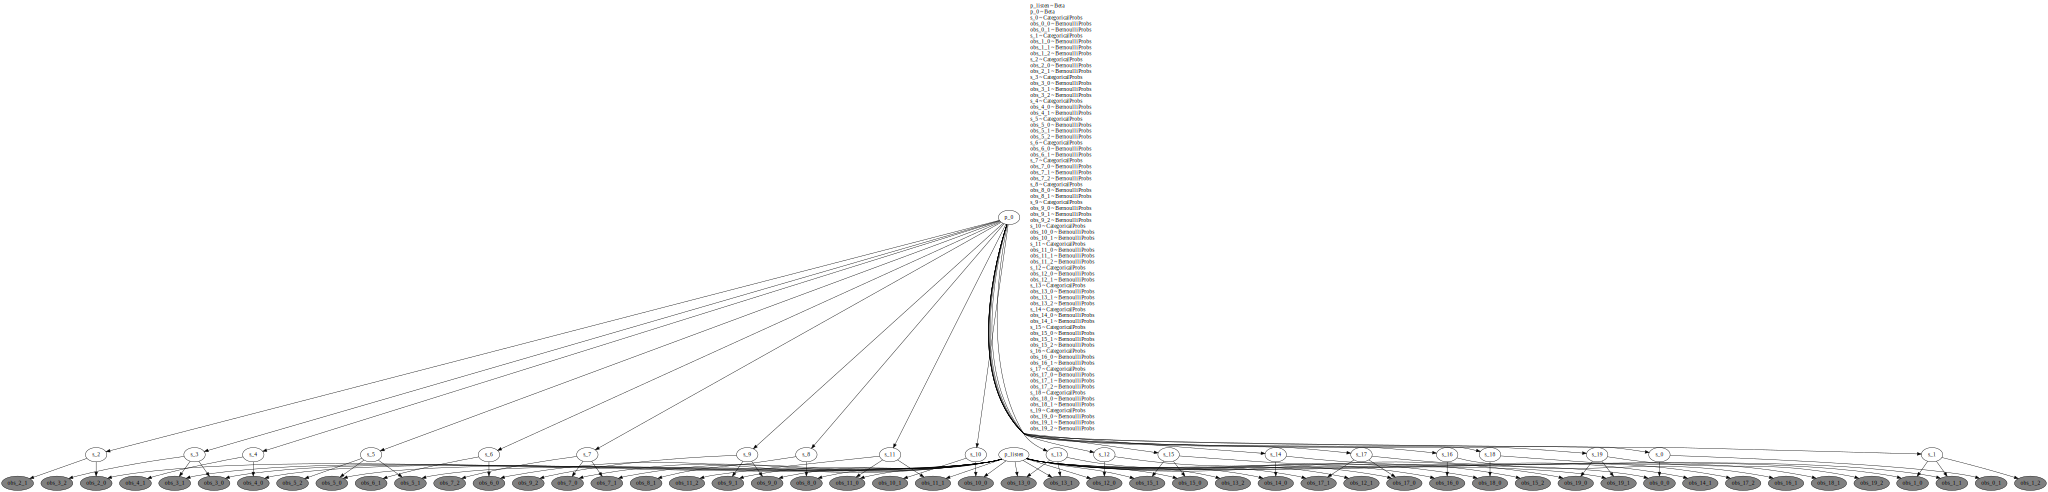

In [182]:
numpyro.render_model(model1, model_args=(data_numeric_2,), render_distributions=True, render_params=True,)

In [93]:
mcmc_3 = inference(model1, data_numeric_2)

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       p_0      0.26      0.09      0.26      0.11      0.41  16008.21      1.00
  p_listen      0.85      0.06      0.86      0.75      0.95  14377.13      1.00

Number of divergences: 0


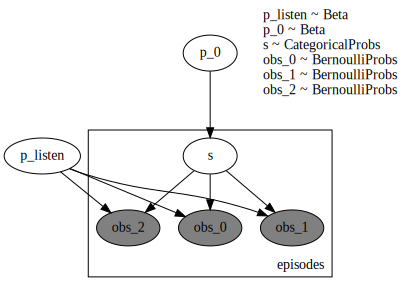

In [150]:
numpyro.render_model(model2, model_args=(data_numeric_2,), render_distributions=True, render_params=True,)

In [183]:
mcmc_4 = inference(model2, data_numeric_2)

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       p_0      0.26      0.09      0.26      0.11      0.41  17303.86      1.00
  p_listen      0.85      0.06      0.86      0.75      0.95  16364.42      1.00

Number of divergences: 0


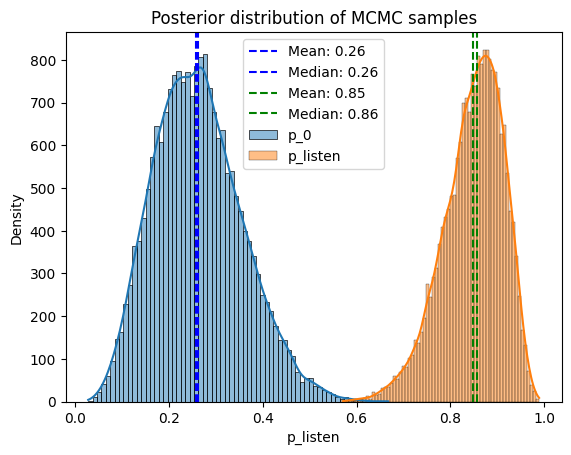

In [187]:
plot_samples(mcmc_4.get_samples())